In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np
import scipy 
%matplotlib notebook

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import warnings
warnings.filterwarnings('ignore')

In [3]:
audio_dir = '../../ESC-50/audio/'
path_to_db='../../ESC-50/'

In [5]:
import librosa
import numpy as np
import librosa.display
import time 
import gc #（garbage collector）
for fileList in os.walk(audio_dir):
    count = 0
    for fname in fileList[2]:
        t1 = time.time()
        count += 1
        name_array = fname.split('.')
        name = name_array[0]
        name_array = name_array[0].split('-')
        curr_class = name_array[-1]
        if(name != '' and curr_class != ''):
            fpath = audio_dir + fname
            (sig, rate) = librosa.load(fpath, sr=None, mono=True,  dtype=np.float32)
            S = librosa.feature.melspectrogram(y=sig, sr=rate)
            S_dB = librosa.power_to_db(S)
            S_dB = S_dB.astype(np.float32)
    
            save_dir = './data2/class' + str(curr_class) + '/'
            
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            np.save(save_dir + name + '.npy',S_dB)
        t2 = time.time()


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (3,6))
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 32, (4,4))
        self.norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 32, (3,6))
        self.norm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(6,)
        
        self.fc1 = nn.Linear(500, 50)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(64, 50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        x = self.softmax(x)
        return x

model = Net()
print(model)
model.cuda()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 6), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 6), stride=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)


Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 6), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 6), stride=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=6, stride=6, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)

In [ ]:
# load data:
from PIL import Image
import os 
import numpy as np
from torch.utils.data import Dataset, DataLoader

class trainset(Dataset):
    def __init__(self):
        
        root = "./data2/"
        self.data_list = []
        self.label_list = []
        for root, dir, files in os.walk("./data2/"):
            for file in files:
                if file.find('.npy')!= -1:
                    self.data_list.append(os.path.join(root, file))
                    self.label_list.append(int(root[13:]))
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        path = self.data_list[index]
        data = np.load(path,allow_pickle = True)
        data = np.expand_dims(data, axis=0)
        label= self.label_list[index] 
        label = np.asarray(label)
        
        return data, label
dataloader = trainset()
data,label = dataloader.__getitem__(410)
print(data.shape, label)

In [15]:
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import time
from torch.optim.lr_scheduler import StepLR

device = 0


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

validation_split = .25
random_seed= 42
shuffle_dataset = True
dataset_size = 2000
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
batch_size = 5

dataset  = trainset()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
valloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(100):  # loop over the dataset multiple times
        
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))

    
    print('Finished Training')
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(valloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.long().to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
    print("Validation done.Proceeding to the next iteration")



2000 2000


RuntimeError: CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 4.00 GiB total capacity; 2.88 GiB already allocated; 6.80 MiB free; 22.86 MiB cached)

<IPython.core.display.Javascript object>


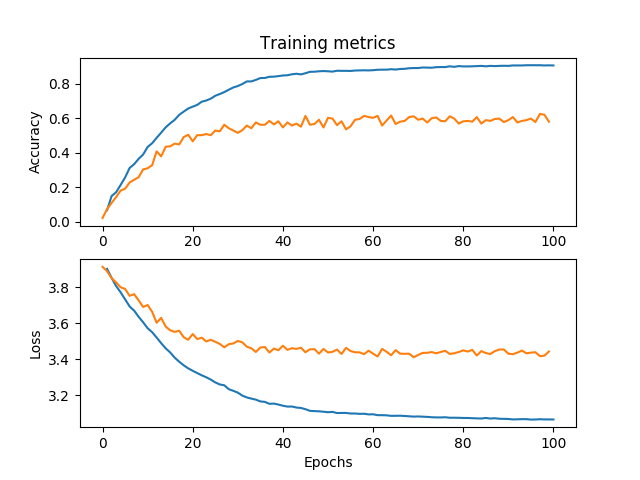

In [14]:
x_axis = np.linspace(1,100,100)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [15]:
torch.save(model, './model_60.pt')

/root/anaconda3/envs/netdissect/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
